### In this notebook we will briefly talk about what XGBoost is and then apply it to our data (GDP per capita) and then we will evaluate our model

NOTE: We will both tackle CLASSIFICATION and REGRESSION problems

CLASSIFICATION: ML problem in which the output variable is a category, in discrete numerical values

REGRESSION: ML problem in which the model predicted output is a continuous numerical value

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, accuracy_score

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix

Next, we import the functions from our original data exploration notebook. These will be used to get our data clean enough to be fed to our models.

In [2]:
# FUNCTIONS FROM NOTEBOOK 1

def merge_data(country_data, height_data):
  height_data = height_data.rename(columns={"Country Name" : "Country"})
  country_data['Country'] = country_data.apply(lambda row : row.astype(str)['Country'][:-1], axis=1)
  old_names = ['Antigua & Barbuda', 'Bahamas, The', 'Bosnia & Herzegovina', 'Central African Rep.', 'Congo, Dem. Rep.', 'Swaziland', 'Gambia, The', 'Cote d\'Ivoire',
             'Micronesia, Fed. St.', 'Burma', 'Korea, North', 'Macedonia', 'Congo, Repub. of the', 'Saint Kitts & Nevis', 'Sao Tome & Principe',
             'Korea, South', 'East Timor', 'Trinidad & Tobago']

  new_names = ['Antigua and Barbuda', 'Bahamas', 'Bosnia and Herzegovina', 'Central African Republic', 'DR Congo', 'Eswatini', 'Gambia', 'Ivory Coast', 'Micronesia',
              'Myanmar', 'North Korea', 'North Macedonia', 'Republic of the Congo', 'Saint Kitts and Nevis', 'Sao Tome and Principe', 'South Korea',
              'Timor-Leste', 'Trinidad and Tobago']

  for i in range(len(old_names)):
    country_data['Country'].replace({old_names[i]: new_names[i]}, inplace=True)
  
  merged_df = pd.merge(country_data, height_data, on=['Country'])
  return merged_df

# FUNCTIONS FROM NOTEBOOK 2

def rename_regions(row):
  if row['Region'] == 'ASIA (EX. NEAR EAST)':
    region = 'ASIA'
  elif row['Region'] == 'NEAR EAST':
    region = 'MIDDLE EAST'
  elif row['Region'] == 'C.W. OF IND. STATES':
    region = "C.W.I. STATES"
  else:
    region = row['Region']
  return region

def format_and_clean_data(merged_data):
  merged_data['Region'] = merged_data.apply(lambda row : row.astype(str)['Region'].strip(), axis=1)
  merged_data['Region'] = merged_data.apply(lambda row : rename_regions(row), axis=1)

  for col in merged_data.columns.values:
    if merged_data[col].isnull().sum() == 0:
        continue
    if col == 'Climate':
        guess_values = merged_data.groupby('Region')['Climate'].apply(lambda x: x.mode().max())
    else:
        guess_values = merged_data.groupby('Region')[col].median()
    for region in merged_data['Region'].unique():
        merged_data[col].loc[(merged_data[col].isnull())&(merged_data['Region']==region)] = guess_values[region]
  return merged_data

# FUNCTIONS FROM NOTEBOOK 3

def get_gdp_dataset(merged_data):
  merged_data = merged_data.drop(['Male Height in Cm', 'Female Height in Cm'], axis=1)
  merged_data['Average Height in Ft'] = merged_data['Female Height in Ft'] / 2 + merged_data['Male Height in Ft'] / 2
  merged_data = merged_data.drop(['Male Height in Ft', 'Female Height in Ft'], axis=1)

  GDP_features = ['GDP ($ per capita)', 'Infant mortality (per 1000 births)', 'Net migration', 'Pop. Density (per sq. mi.)',
                'Literacy (%)', 'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry', 'Service']
  gdp_data = merged_data[GDP_features]
  
  return gdp_data

def get_height_dataset(merged_data):
  merged_data = merged_data.drop(['Male Height in Cm', 'Female Height in Cm'], axis=1)
  merged_data['Average Height in Ft'] = merged_data['Female Height in Ft'] / 2 + merged_data['Male Height in Ft'] / 2
  merged_data = merged_data.drop(['Male Height in Ft', 'Female Height in Ft'], axis=1)

  height_features = ['Average Height in Ft', 'Agriculture', 'Service', 'Phones (per 1000)', 'GDP ($ per capita)', 'Literacy (%)']
  avg_height_data = merged_data[height_features]

  return avg_height_data

Let's get to data preprocessing! First we will use pandas (pd) to read our csv files. Then, we can manipulate the functions above to clean out data.

In [3]:
height_data = pd.read_csv('../content/sample_data/Height of Male and Female by Country 2022.csv')
country_data = pd.read_csv('../content/sample_data/countries of the world.csv', decimal=',')

merged_data = merge_data(country_data, height_data)
merged_data = format_and_clean_data(merged_data)
gdp_data = get_gdp_dataset(merged_data)
avg_height_data = get_height_dataset(merged_data)

gdp_data.head()

,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
0,700.0,163.07,23.06,48.0,36.0,3.2,46.60,0.380,0.240,0.380
1,4500.0,21.52,-4.93,124.6,86.5,71.2,15.11,0.232,0.188,0.579
2,6000.0,31.00,-0.39,13.8,70.0,78.1,17.14,0.101,0.600,0.298
3,8000.0,9.27,-20.71,290.4,97.0,259.5,22.46,0.151,0.190,0.620
4,19000.0,4.05,6.60,152.1,100.0,497.2,8.71,0.021,0.274,0.707


In [4]:
avg_height_data.head()

,Average Height in Ft,Agriculture,Service,Phones (per 1000),GDP ($ per capita),Literacy (%)
0,5.325,0.380,0.380,3.2,700.0,36.0
1,5.515,0.232,0.579,71.2,4500.0,86.5
2,5.535,0.101,0.298,78.1,6000.0,70.0
3,5.655,0.151,0.620,259.5,8000.0,97.0
4,5.650,0.021,0.707,497.2,19000.0,100.0


Features: the input data/variables our ML model takes in to make prediction

Target: the output data/variables our ML model aims to predict

Whenever we train a model, its important to split it up into a training data set and a test data set. The main reason we do this is to make sure that the model learns the patterns in the data instead of just memorizing the entire dataset. Basically, we want to make sure that the model doesn't overfit on the data. Its like when you get a review for a test, you are given questions that are similar to the test but not the exact same question to make sure you can't just memorize the questions on the review.

### Overfitting: happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data

For this example, 70% of our data will consist of training data, while the rest of 30% will be testing data

train_X and train_Y will be the training feature, target respectively. test_X and test_Y will be the testing feature, target respectively.

We're also shuffling our data so that every data entry has an equal chance of being selected for testing data, incase certain groups of data were concentrated

In [10]:
train, test = train_test_split(gdp_data, test_size=0.3, shuffle=True)
training_features = ['Infant mortality (per 1000 births)',
       'Net migration', 'Pop. Density (per sq. mi.)', 'Literacy (%)',
       'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry',
       'Service']
target = 'GDP ($ per capita)'
train_X = train[training_features] # 136 instances of data, each with 9 features
train_Y = train[target] # 136 instances of data, each with 1 target to predict
test_X = test[training_features] # 59 instances of data, each with 9 features
test_Y = test[target] # 59 instances of data, each with 1 target to predict

In the next block, we create our model using sklearn. Sklearn makes it super easy to set up the model and train it on the data, simply create the model and then give it the training data and it will start to learn. After the model is trained, we feed it the test data and compare its answers to the actual answers. This allows us to evaluate how good of a model it is. For our first metric we are using mean absolute error. This is how far from the correct answer the model is on average. Then we use the .describe() function to see what the standard diviation of the dataset to get a better idea of how good or bad the mean average error is in relation to the actual dataset.

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. Learn more here: https://www.youtube.com/watch?v=0Xc9LIb_HTw

For this REGRESSION Problem, we will evaluate our model with the metric MAE(Mean Absolute Error)

MAE: the magnitude of difference between the prediction of an observation and the true value of that observation. Calculation: Find all of your absolute errors: absolute value of -> (Actual Value — Predicted Value). Add them all up. Divide by the number of errors.

In [5]:
#NOTE Let's tackle an REGRESSION Probelem with XGBoost
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_Y , verbose=False)

predictions = XGBModel.predict(test_X)
print(mean_absolute_error(test_Y , predictions))
gdp_data.describe()

1955.4961113364009


,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
count,195.000000,195.000000,195.000000,195.000000,195.00000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,8953.333333,38.936846,-0.437077,201.308205,82.29641,198.387179,22.889744,0.158349,0.293564,0.547195
std,9894.829779,36.382098,4.466701,667.646406,20.01014,199.670583,11.359249,0.149453,0.135160,0.154904
min,500.000000,2.290000,-20.990000,0.000000,17.60000,0.200000,7.290000,0.000000,0.040000,0.062000
25%,1800.000000,10.020000,-1.315000,26.800000,69.95000,27.100000,12.835000,0.039000,0.203500,0.425500
50%,5000.000000,24.310000,0.000000,69.800000,92.30000,131.800000,20.690000,0.112000,0.275000,0.560000
75%,12050.000000,62.550000,0.305000,151.000000,98.00000,305.550000,30.815000,0.231000,0.349000,0.665000
max,55100.000000,191.190000,23.060000,6482.200000,100.00000,898.000000,50.730000,0.769000,0.906000,0.906000


We will also try to create a discrete prediction with our XGBoost model. To achieve this, we break up the different GDPs into 5 equally sized buckets. These represent a label, either very poor, poor, average, wealthy or very wealthy

In [6]:
gdp_data['GDP ($ per capita)'] = pd.qcut(gdp_data['GDP ($ per capita)'], 5, labels=False)
gdp_data.describe()

,GDP ($ per capita),Infant mortality (per 1000 births),Net migration,Pop. Density (per sq. mi.),Literacy (%),Phones (per 1000),Birthrate,Agriculture,Industry,Service
count,195.000000,195.000000,195.000000,195.000000,195.00000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2.000000,38.936846,-0.437077,201.308205,82.29641,198.387179,22.889744,0.158349,0.293564,0.547195
std,1.417854,36.382098,4.466701,667.646406,20.01014,199.670583,11.359249,0.149453,0.135160,0.154904
min,0.000000,2.290000,-20.990000,0.000000,17.60000,0.200000,7.290000,0.000000,0.040000,0.062000
25%,1.000000,10.020000,-1.315000,26.800000,69.95000,27.100000,12.835000,0.039000,0.203500,0.425500
50%,2.000000,24.310000,0.000000,69.800000,92.30000,131.800000,20.690000,0.112000,0.275000,0.560000
75%,3.000000,62.550000,0.305000,151.000000,98.00000,305.550000,30.815000,0.231000,0.349000,0.665000
max,4.000000,191.190000,23.060000,6482.200000,100.00000,898.000000,50.730000,0.769000,0.906000,0.906000


We will have to retrain the model with the new labels. In the next block we reset the data but with the new labels and then feed it into our XGBoost model again.

In [7]:
train, test = train_test_split(gdp_data, test_size=0.3, shuffle=True)
training_features = ['Infant mortality (per 1000 births)',
       'Net migration', 'Pop. Density (per sq. mi.)', 'Literacy (%)',
       'Phones (per 1000)', 'Birthrate', 'Agriculture', 'Industry',
       'Service']
target = 'GDP ($ per capita)'
train_X = train[training_features] # 136 instances of data, each with 9 features
train_Y = train[target] # 136 instances of data, each with 5 different possible target to predict
test_X = test[training_features] # 59 instances of data, each with 9 features
test_Y = test[target] # 59 instances of data, each with 5 different possible target to predict

Because this is a discrete model, we can create a confusion matrix to see where the model is going wrong and see what it is misclassifying. This is a great way to visualize the evaluation metrics. For this confusion matrix, we use sklearn.metrics.

### A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model.

Let say row 1 and column 1 represent the target class "Poor". Then, cf_matrix[1][1] tells that 4 predictions were made accurately for the target class "Poor"

Let say row 0 represent the target class "Very Poor" and column 1 represent the target class "Poor". Then, cf_matrix[0][1] tells that 8 predictions were made incurrately where: the model predicted 8 target classes of "Poor", but they were actually supposed to be the target class "Very Poor"

In [8]:
#NOTE Let's tackle an CLASSIFICATION Probelem with XGBoost
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_Y , verbose=False)

predictions = XGBModel.predict(test_X)
adj_predictions = []
for prediction in predictions:
  adj_predictions.append(round(prediction))
predictions = np.array(adj_predictions)

cf_matrix = confusion_matrix(np.array(test_Y), predictions)
cf_matrix

array([[6, 2, 0, 0, 0],
       [4, 7, 1, 0, 0],
       [1, 4, 4, 3, 0],
       [0, 0, 4, 9, 0],
       [0, 0, 0, 7, 7]], dtype=int64)

With our confusion matrix set up, we will now set up the heatmap to show it off in a more visually appealing way. We will need to create the title, x-axis label, y-axis label, and the different labels for the different sections.

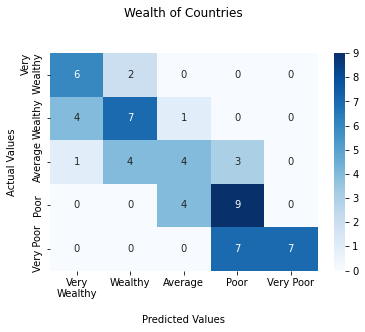

In [9]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Very\nWealthy','Wealthy','Average','Poor','Very Poor'])
ax.yaxis.set_ticklabels(['Very\n Wealthy','Wealthy','Average','Poor','Very Poor'])

## Display the visualization of the Confusion Matrix.
plt.show()

For the next confusion matrix, I wanted to see the % of each answer within a row.

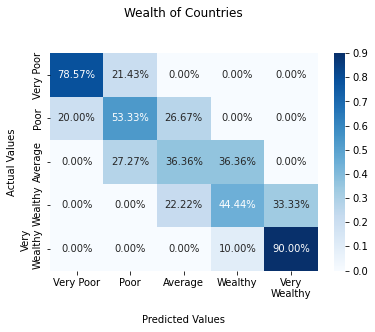

In [16]:
cf_matrix = confusion_matrix(np.array(test_Y), predictions)
percent_matrix = []
for i in range(len(cf_matrix)):
  percent_matrix.append(cf_matrix[i]/sum(cf_matrix[i]))

ax = sns.heatmap(percent_matrix, annot=True, cmap='Blues', fmt='.2%')

ax.set_title('Wealth of Countries\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])
ax.yaxis.set_ticklabels(['Very Poor','Poor','Average','Wealthy','Very\nWealthy'])

plt.show()

Finally, we will print out the raw accuacy of our model, meaning how often it labeled the country correctly.

Accuracy Score: the ratio of number of correct predictions to the total number of input samples. Calculation: (number of labels accurately predicted) / (total instance of labels)

Note: 100% is the best accuracy there is, but be suspicious because this might be a result of overfitting

### Overfitting: happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data

In [11]:
accuracy_score(np.array(test_Y), predictions)

0.1864406779661017

#### Why is our model's accuracy so low? Possibilities that can explain this:
#### 	1) The input data and output target have a very low correlation.
#### 	2) There isn't enough data for the model to learn anything...
#### 	3) The model is too weak and is unable to pick up correlations from the data.